#MultiClass Emotion Recognition Using Fer-2013 Dataset

In [1]:
%cd /content/drive/MyDrive/senior-project/CNNs/

/content/drive/MyDrive/senior-project/CNNs


In [2]:
!pip install utils
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 15.4 MB/s 
     |████████████████████████████████| 381 kB 77.0 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but y

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

###Load Data

In [4]:
data = pd.read_csv('fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [5]:
def show(img):
  show_image = img.reshape(48,48)
  plt.axis("off")
  plt.imshow(show_image, cmap="gray")

In [6]:
data.shape

(35887, 3)

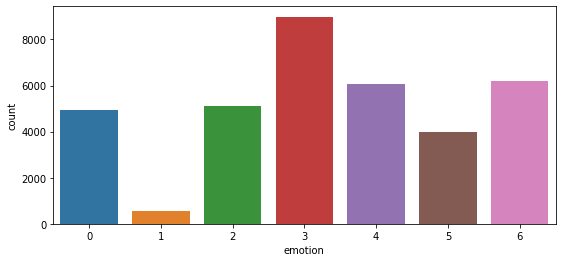

In [7]:
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=data)

In [8]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

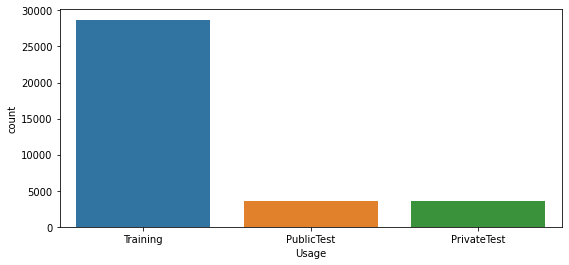

In [9]:
plt.figure(figsize=(9,4))
sns.countplot(x='Usage', data=data)

###Scale Data

In [10]:
import cv2
image_size=(48,48)

In [11]:
pixels = data['pixels'].tolist() # Converting the relevant column element into a list for each row
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')] # Splitting the string by space character as a list
  face = np.asarray(face).reshape(width, height) #converting the list to numpy array in size of 48*48
  face = cv2.resize(face.astype('uint8'),image_size) #resize the image to have 48 cols (width) and 48 rows (height)
  faces.append(face.astype('float32')) #makes the list of each images of 48*48 and their pixels in numpyarray form
  
faces = np.asarray(faces) #converting the list into numpy array
faces = np.expand_dims(faces, -1) #Expand the shape of an array -1=last dimension => means color space
emotions = pd.get_dummies(data['emotion']).to_numpy() #doing the one hot encoding type on emotions

In [12]:
faces[0]

array([[[ 70.],
        [ 80.],
        [ 82.],
        ...,
        [ 52.],
        [ 43.],
        [ 41.]],

       [[ 65.],
        [ 61.],
        [ 58.],
        ...,
        [ 56.],
        [ 52.],
        [ 44.]],

       [[ 50.],
        [ 43.],
        [ 54.],
        ...,
        [ 49.],
        [ 56.],
        [ 47.]],

       ...,

       [[ 91.],
        [ 65.],
        [ 42.],
        ...,
        [ 72.],
        [ 56.],
        [ 43.]],

       [[ 77.],
        [ 82.],
        [ 79.],
        ...,
        [105.],
        [ 70.],
        [ 46.]],

       [[ 77.],
        [ 72.],
        [ 84.],
        ...,
        [106.],
        [109.],
        [ 82.]]], dtype=float32)

In [13]:
print(faces.shape)
print(faces[0].ndim)
print(type(faces))

(35887, 48, 48, 1)
3
<class 'numpy.ndarray'>


In [14]:
print(emotions[0]) #Emotion after preprocessing

[1 0 0 0 0 0 0]


###Data Processing

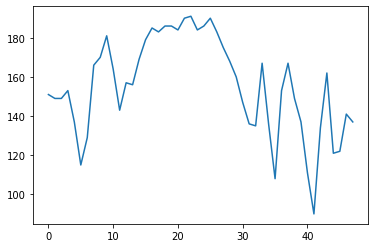

In [15]:
x = faces.astype('float32')
plt.plot(x[1,1])
plt.show()

In [16]:
x = x / 255.0 #Dividing the pixels by 255 for normalization  => range(0,1)

# Scaling the pixels value in range(-1,1)
x = x - 0.5
x = x * 2.0
x[0]

array([[[-0.45098037],
        [-0.372549  ],
        [-0.35686272],
        ...,
        [-0.5921569 ],
        [-0.6627451 ],
        [-0.6784314 ]],

       [[-0.49019605],
        [-0.52156866],
        [-0.54509807],
        ...,
        [-0.56078434],
        [-0.5921569 ],
        [-0.654902  ]],

       [[-0.60784316],
        [-0.6627451 ],
        [-0.5764706 ],
        ...,
        [-0.6156863 ],
        [-0.56078434],
        [-0.6313726 ]],

       ...,

       [[-0.2862745 ],
        [-0.49019605],
        [-0.67058825],
        ...,
        [-0.4352941 ],
        [-0.56078434],
        [-0.6627451 ]],

       [[-0.3960784 ],
        [-0.35686272],
        [-0.38039213],
        ...,
        [-0.17647058],
        [-0.45098037],
        [-0.6392157 ]],

       [[-0.3960784 ],
        [-0.4352941 ],
        [-0.34117645],
        ...,
        [-0.16862744],
        [-0.14509803],
        [-0.35686272]]], dtype=float32)

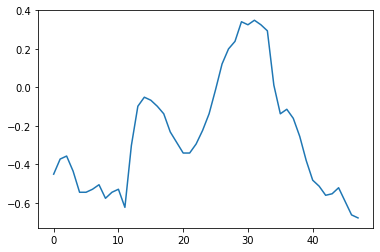

In [17]:
plt.plot(x[0,0])
plt.show()

In [18]:
x.min(),x.max() # we can observe that pixels are scale

(-1.0, 1.0)

###Split Data

In [22]:
num_samples, num_classes = emotions.shape

num_samples = len(x)
num_train_samples = int((1 - 0.2)*num_samples)

# Traning data
x_train = x[:num_train_samples]
y_train = emotions[:num_train_samples]

# Validation data
x_test = x[num_train_samples:]
y_test = emotions[num_train_samples:]

train_data = (x_train, y_train)
val_data = (x_test, y_test)

In [24]:
print('Training Pixels',x_train.shape)  # ==> 4 dims -  no of images , width , height , color
print('Training labels',y_train.shape)

print('Validation Pixels',x_test.shape)
print('Validation labels',y_test.shape)

Training Pixels (28709, 48, 48, 1)
Training labels (28709, 7)
Validation Pixels (7178, 48, 48, 1)
Validation labels (7178, 7)


###Model Building

In [25]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# data generator Generate batches of tensor image data with real-time data augmentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


In [28]:
datasets = ['fer2013']
num_epochs = 30
base_path="/content"
batch_size = 32
for dataset_name in datasets:
    print('Training dataset:', dataset_name)

    #callbacks
    log_file_path = dataset_name + '_emotion_training.log'

    csv_logger = CSVLogger(log_file_path, append=False)
    early_stop = EarlyStopping('val_loss', patience=50)
    reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,patience=int(50/4), verbose=1)
    
    trained_models_path = base_path + dataset_name + 'simple_cnn'
    model_names = trained_models_path + '.{epoch:02d}-{val_loss:.2f}.hdf5'      # if error "acc" in 1 line ... don't confuse check entire block since fit() generates a inner loop
    model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
    my_callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

    # loading dataset
    train_faces, train_emotions = train_data
    history=model.fit_generator(data_generator.flow(train_faces, train_emotions,
                                            batch_size),
                        epochs=num_epochs, verbose=1
                        ,callbacks=my_callbacks,validation_data =val_data)   #not callbacks = [my_callbacks] since we my_callbacks is already

Training dataset: fer2013
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


898/898 [==============================] - ETA: 0s - loss: 1.8686 - accuracy: 0.2677
Epoch 1: val_loss improved from inf to 1.76141, saving model to /contentfer2013simple_cnn.01-1.76.hdf5
898/898 [==============================] - 55s 46ms/step - loss: 1.8686 - accuracy: 0.2677 - val_loss: 1.7614 - val_accuracy: 0.3158 - lr: 5.0000e-04
Epoch 2/30
897/898 [============================>.] - ETA: 0s - loss: 1.5946 - accuracy: 0.3869
Epoch 2: val_loss improved from 1.76141 to 1.38177, saving model to /contentfer2013simple_cnn.02-1.38.hdf5
898/898 [==============================] - 40s 45ms/step - loss: 1.5940 - accuracy: 0.3872 - val_loss: 1.3818 - val_accuracy: 0.4606 - lr: 5.0000e-04
Epoch 3/30
898/898 [==============================] - ETA: 0s - loss: 1.4410 - accuracy: 0.4465
Epoch 3: val_loss improved from 1.38177 to 1.37366, saving model to /contentfer2013simple_cnn.03-1.37.hdf5
898/898 [==============================] - 40s 45ms/step - loss: 1.4410 - accuracy: 0.4465 - val_loss: 1.3

In [44]:
from keras.preprocessing.image import ImageDataGenerator

In [50]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [51]:
!ls

 10.jpg			        imageclassifier.h5
 binary_emotion.h5	        logs
 data			        london.txt
'Deep Face Detection'	        model_arch.png
 Face_Emotion_detection.h5      model.json
 face_model.json	        models
 fer2013.csv		        PrivateTest_11524863.jpg
 fer2013_emotion_training.log   test.mp4


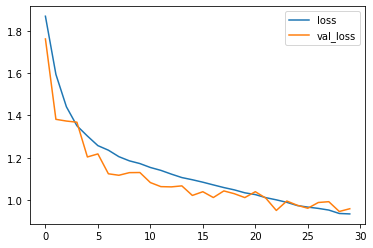

In [29]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label ='val_loss')
plt.legend()

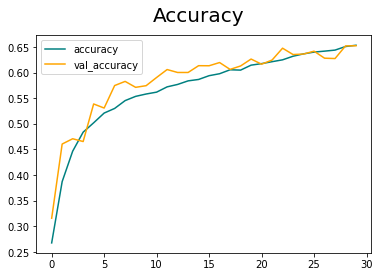

In [30]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [31]:
!pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [33]:
y_pred = model.predict(x_test)

In [34]:
y_pred_classes = []

In [35]:
import operator
for i in range(len(y_pred)):
  index, value = max(enumerate(y_pred[i]), key=operator.itemgetter(1))
  y_pred_classes.append(index)

In [36]:
y_pred = y_pred_classes

In [37]:
y_pred[0]

6

In [38]:
y_test_classes = []

In [39]:
for i in range(len(y_test)):
  index, value = max(enumerate(y_test[i]), key=operator.itemgetter(1))
  y_test_classes.append(index)

In [40]:
y_test = y_test_classes

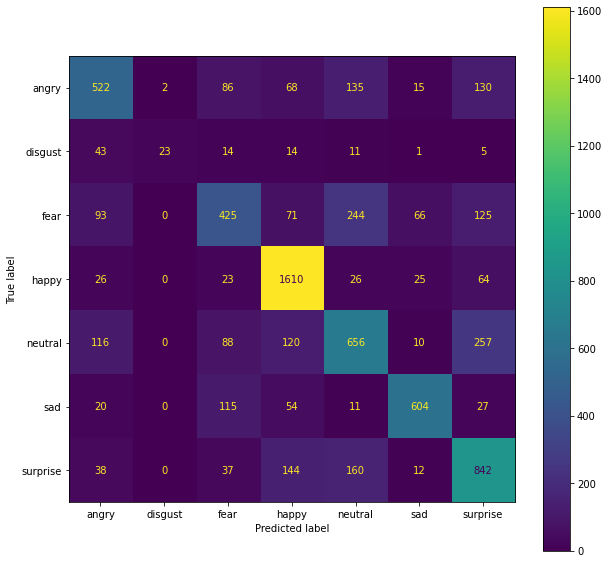

In [41]:
cm = confusion_matrix(y_test,y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['angry', 'disgust','fear','happy','neutral','sad','surprise'])
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)

In [42]:
help(model)

Help on Sequential in module keras.engine.sequential object:

class Sequential(keras.engine.functional.Functional)
 |  Sequential(*args, **kwargs)
 |  
 |  `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
 |  
 |  `Sequential` provides training and inference features on this model.
 |  
 |  Examples:
 |  
 |  ```python
 |  # Optionally, the first layer can receive an `input_shape` argument:
 |  model = tf.keras.Sequential()
 |  model.add(tf.keras.layers.Dense(8, input_shape=(16,)))
 |  # Afterwards, we do automatic shape inference:
 |  model.add(tf.keras.layers.Dense(4))
 |  
 |  # This is identical to the following:
 |  model = tf.keras.Sequential()
 |  model.add(tf.keras.Input(shape=(16,)))
 |  model.add(tf.keras.layers.Dense(8))
 |  
 |  # Note that you can also omit the `input_shape` argument.
 |  # In that case the model doesn't have any weights until the first call
 |  # to a training/evaluation method (since it isn't yet built):
 |  model = tf.keras.Sequenti

In [43]:
# model.save('Face_Emotion_detection.h5')